In [1]:
import pandas as pd
import deepxde as dde
import numpy as np
import re
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from deepxde.backend import tf

In [3]:
H = dde.Variable(1.6)
D = dde.Variable(0.2)

In [4]:
# '''
# 24th July, 2023 created by Likun Chen, Wuhan University
# This is for testing the PINN parameter estimation, object: syn-machine
# EXT Parameters:
#     Vi , initial terminal voltage : 1.0 pu
#     Ta , voltage regulator time constant : 0.4 sec
#     Kf , rate feedback gain : 0.03
# SYN Parameters:
#     H , inertia constant : 1.7 MWs/MVA
#     D , synchronous mechanical damping : 0.12 pu/pu
#     Xa , stator leakage reactance : 0.130 pu
#     Xd , d-axis unsaturated reactance : 1.79 pu
#     Xd' , d-axis unsaturated transient reactance : 0.169 pu
#     Xd'' , d-axis unsaturated Sub-Trans reactance : 0.135 pu
#     Xq , q-axis unsaturated reactance : 1.71 pu
#     Xq' , q-axis unsaturated transient reactance : 0.228 pu
#     Xq'' , q-axis unsaturated Sub-Trans reactance : 0.2 pu
# For 2-order equation, the state variables are rev (w) and phase angle (delta), 
# parameters waiting estimated are H , D , Eq' = Ed' = const
#     H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
#     P_ex is external power balance and P_mach is the mechanical power
#     time， P_ex, delta, P_mach, dw
# '''

In [5]:
'''
import numpy as np
import deepxde as dde
from deepxde.backend import tf
import variable_to_parameter_transform


def sbinn(data_t, data_y, meal_t, meal_q):
    def get_variable(v, var):
        low, up = v * 0.2, v * 1.8
        l = (up - low) / 2
        v1 = l * tf.tanh(var) + l + low
        return v1

    E_ = dde.Variable(0.0)
    tp_ = dde.Variable(0.0)
    ti_ = dde.Variable(0.0)
    td_ = dde.Variable(0.0)
    k_ = dde.Variable(0.0)
    Rm_ = dde.Variable(0.0)
    a1_ = dde.Variable(0.0)
    C1_ = dde.Variable(0.0)
    C2_ = dde.Variable(0.0)
    C4_ = dde.Variable(0.0)
    C5_ = dde.Variable(0.0)
    Ub_ = dde.Variable(0.0)
    U0_ = dde.Variable(0.0)
    Um_ = dde.Variable(0.0)
    Rg_ = dde.Variable(0.0)
    alpha_ = dde.Variable(0.0)
    beta_ = dde.Variable(0.0)

    var_list_ = [
        E_,
        tp_,
        ti_,
        td_,
        k_,
        Rm_,
        a1_,
        C1_,
        C2_,
        C4_,
        C5_,
        Ub_,
        U0_,
        Um_,
        Rg_,
        alpha_,
        beta_,
    ]

    def ODE(t, y):
        Ip = y[:, 0:1]
        Ii = y[:, 1:2]
        G = y[:, 2:3]
        h1 = y[:, 3:4]
        h2 = y[:, 4:5]
        h3 = y[:, 5:6]

        Vp = 3
        Vi = 11
        Vg = 10
        E = (tf.tanh(E_) + 1) * 0.1 + 0.1
        tp = (tf.tanh(tp_) + 1) * 2 + 4
        ti = (tf.tanh(ti_) + 1) * 40 + 60
        td = (tf.tanh(td_) + 1) * 25 / 6 + 25 / 3
        k = get_variable(0.0083, k_)
        Rm = get_variable(209, Rm_)
        a1 = get_variable(6.6, a1_)
        C1 = get_variable(300, C1_)
        C2 = get_variable(144, C2_)
        C3 = 100
        C4 = get_variable(80, C4_)
        C5 = get_variable(26, C5_)
        Ub = get_variable(72, Ub_)
        U0 = get_variable(4, U0_)
        Um = get_variable(90, Um_)
        Rg = get_variable(180, Rg_)
        alpha = get_variable(7.5, alpha_)
        beta = get_variable(1.772, beta_)

        f1 = Rm * tf.math.sigmoid(G / (Vg * C1) - a1)
        f2 = Ub * (1 - tf.math.exp(-G / (Vg * C2)))
        kappa = (1 / Vi + 1 / (E * ti)) / C4
        f3 = (U0 + Um / (1 + tf.pow(tf.maximum(kappa * Ii, 1e-3), -beta))) / (Vg * C3)
        f4 = Rg * tf.sigmoid(alpha * (1 - h3 / (Vp * C5)))
        dt = t - meal_t
        IG = tf.math.reduce_sum(
            0.5 * meal_q * k * tf.math.exp(-k * dt) * (tf.math.sign(dt) + 1),
            axis=1,
            keepdims=True,
        )
        tmp = E * (Ip / Vp - Ii / Vi)
        dIP_dt = dde.grad.jacobian(y, t, i=0, j=0)
        dIi_dt = dde.grad.jacobian(y, t, i=1, j=0)
        dG_dt = dde.grad.jacobian(y, t, i=2, j=0)
        dh1_dt = dde.grad.jacobian(y, t, i=3, j=0)
        dh2_dt = dde.grad.jacobian(y, t, i=4, j=0)
        dh3_dt = dde.grad.jacobian(y, t, i=5, j=0)
        return [
            dIP_dt - (f1 - tmp - Ip / tp),
            dIi_dt - (tmp - Ii / ti),
            dG_dt - (f4 + IG - f2 - f3 * G),
            dh1_dt - (Ip - h1) / td,
            dh2_dt - (h1 - h2) / td,
            dh3_dt - (h2 - h3) / td,
        ]

    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Observes
    n = len(data_t)
    idx = np.append(
        np.random.choice(np.arange(1, n - 1), size=n // 5, replace=False), [0, n - 1]
    )
    observe_y2 = dde.PointSetBC(data_t[idx], data_y[idx, 2:3], component=2)

    np.savetxt("glucose_input.dat", np.hstack((data_t[idx], data_y[idx, 2:3])))

    data = dde.data.PDE(geom, ODE, [observe_y2], anchors=data_t)

    net = dde.maps.FNN([1] + [128] * 3 + [6], "swish", "Glorot normal")

    def feature_transform(t):
        t = 0.01 * t
        return tf.concat(
            (t, tf.sin(t), tf.sin(2 * t), tf.sin(3 * t), tf.sin(4 * t), tf.sin(5 * t)),
            axis=1,
        )

    net.apply_feature_transform(feature_transform)

    def output_transform(t, y):
        idx = 1799
        k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
        b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (
            data_t[idx] - data_t[0]
        )
        linear = k * t + b
        factor = tf.math.tanh(t) * tf.math.tanh(idx - t)
        return linear + factor * tf.constant([1, 1, 1e2, 1, 1, 1]) * y

    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)

    firsttrain = 10000
    callbackperiod = 1000
    maxepochs = 1000000

    model.compile("adam", lr=1e-3, loss_weights=[0, 0, 0, 0, 0, 0, 1e-2])
    model.train(epochs=firsttrain, display_every=1000)
    model.compile(
        "adam",
        lr=1e-3,
        loss_weights=[1, 1, 1e-2, 1, 1, 1, 1e-2],
        external_trainable_variables=var_list_,
    )
    variablefilename = "variables.csv"
    variable = dde.callbacks.VariableValue(
        var_list_, period=callbackperiod, filename=variablefilename
    )
    losshistory, train_state = model.train(
        epochs=maxepochs, display_every=1000, callbacks=[variable]
    )

    dde.saveplot(losshistory, train_state, issave=True, isplot=True)


gluc_data = np.hsplit(np.loadtxt("glucose.dat"), [1])
meal_data = np.hsplit(np.loadtxt("meal.dat"), [4])

t = gluc_data[0]
y = gluc_data[1]
meal_t = meal_data[0]
meal_q = meal_data[1]

sbinn(
    t[:1800],
    y[:1800],
    meal_t,
    meal_q,
)

variable_to_parameter_transform.variable_file(10000, 1000, 1000000, "variables.csv")
'''

'\nimport numpy as np\nimport deepxde as dde\nfrom deepxde.backend import tf\nimport variable_to_parameter_transform\n\n\ndef sbinn(data_t, data_y, meal_t, meal_q):\n    def get_variable(v, var):\n        low, up = v * 0.2, v * 1.8\n        l = (up - low) / 2\n        v1 = l * tf.tanh(var) + l + low\n        return v1\n\n    E_ = dde.Variable(0.0)\n    tp_ = dde.Variable(0.0)\n    ti_ = dde.Variable(0.0)\n    td_ = dde.Variable(0.0)\n    k_ = dde.Variable(0.0)\n    Rm_ = dde.Variable(0.0)\n    a1_ = dde.Variable(0.0)\n    C1_ = dde.Variable(0.0)\n    C2_ = dde.Variable(0.0)\n    C4_ = dde.Variable(0.0)\n    C5_ = dde.Variable(0.0)\n    Ub_ = dde.Variable(0.0)\n    U0_ = dde.Variable(0.0)\n    Um_ = dde.Variable(0.0)\n    Rg_ = dde.Variable(0.0)\n    alpha_ = dde.Variable(0.0)\n    beta_ = dde.Variable(0.0)\n\n    var_list_ = [\n        E_,\n        tp_,\n        ti_,\n        td_,\n        k_,\n        Rm_,\n        a1_,\n        C1_,\n        C2_,\n        C4_,\n        C5_,\n        

In [6]:
input_data = pd.read_csv('data/927testforTe2.csv')
input_data

,Time,Subsystem #1|CTLs|Vars|Tm,Subsystem #1|Machines|M|TESTSPDOUT,Subsystem #1|Machines|M|TESTTELECT
0,0.00000,0.000000,1.005288,3.309534e-08
1,0.00005,0.000000,1.005288,3.263598e-08
2,0.00010,0.000000,1.005288,3.258290e-08
3,0.00015,0.000000,1.005288,3.293628e-08
4,0.00020,0.000000,1.005288,3.369583e-08
...,...,...,...,...
7995,0.39975,0.914581,0.970005,6.204557e-01
7996,0.39980,0.914565,0.970010,6.204525e-01
7997,0.39985,0.914550,0.970015,6.204492e-01
7998,0.39990,0.914534,0.970020,6.204459e-01


In [7]:
step_time = input_data.Time[1] - input_data.Time[0]
st = 0.5 # start time (10% proportion)
et = 1 # end time
input_data.Time -= step_time * int(input_data.shape[0] * st)
input_data = input_data[int(input_data.shape[0]*st): int(input_data.shape[0]*et)]

In [8]:
input_data.set_index('Time', inplace=True)

In [9]:
input_data.columns=['Tm','w', 'Te']

<Axes: xlabel='Time'>

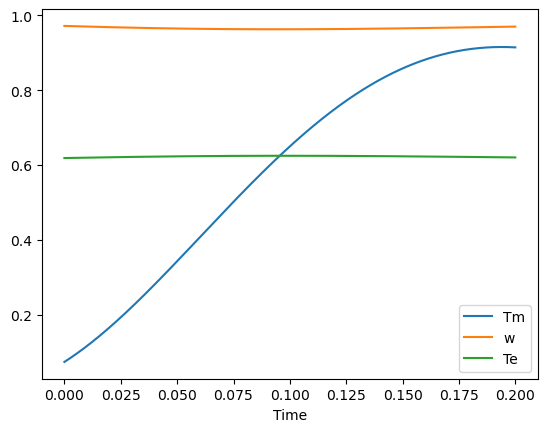

In [10]:
input_data.plot()

In [11]:
input_data = input_data.reindex(columns = ['w','Tm','Te'])
input_data

,w,Tm,Te
Time,,,
0.00000,0.971837,0.074038,0.618821
0.00005,0.971828,0.074231,0.618826
0.00010,0.971819,0.074424,0.618832
0.00015,0.971810,0.074617,0.618837
0.00020,0.971801,0.074810,0.618843
...,...,...,...
0.19975,0.970005,0.914581,0.620456
0.19980,0.970010,0.914565,0.620452
0.19985,0.970015,0.914550,0.620449


In [12]:
x = input_data.index.to_numpy()
x

array([0.0000e+00, 5.0000e-05, 1.0000e-04, ..., 1.9985e-01, 1.9990e-01,
       1.9995e-01])

In [13]:
geom = dde.geometry.TimeDomain(0, x[-1])

In [14]:
# def boundary(_, on_initial):
#     return on_initial

In [15]:
x0 = input_data.iloc[0].tolist()

In [16]:
# # Initial conditions
# ic1 = dde.icbc.IC(geom, lambda X: x0[0], boundary, component=0)
# ic2 = dde.icbc.IC(geom, lambda X: x0[1], boundary, component=1)
# ic3 = dde.icbc.IC(geom, lambda X: x0[2], boundary, component=2)

In [17]:
y = input_data.to_numpy()
y.shape

(4000, 3)

In [18]:
y

array([[0.97183679, 0.07403825, 0.61882093],
       [0.97182778, 0.07423083, 0.61882642],
       [0.97181878, 0.07442363, 0.6188319 ],
       ...,
       [0.97001514, 0.91454953, 0.62044919],
       [0.97002012, 0.91453374, 0.6204459 ],
       [0.9700251 , 0.91451781, 0.62044262]])

In [19]:
observe_t = x.reshape(-1, 1)

In [20]:
# Get the training data
observe_w = dde.PointSetBC(observe_t, y[:, 0:1], component=0)
observe_Tm = dde.PointSetBC(observe_t, y[:, 1:2], component=1)
observe_Te = dde.PointSetBC(observe_t, y[:, 2:3], component=2)

In [21]:
# H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
def Microgrid_system(x, y):
    """Modified Lorenz system (with exogenous input).
    H * d2_delta/dt2 (This is dw/dt) + D * d_delta/dt + P_ex - P_mach = 0
    """
    w, Tm, Te = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    
    dw_dt = dde.grad.jacobian(y, x, i=0, j=0)
    return [
        Tm-Te - 2*H*dw_dt - D*(w-1)
    ]


In [22]:
# class ex_func2():
#     def __init__(self, input_data):
#         self.input_data = input_data
#     def fun(self, t):
#         t = t.reshape(-1, )
#         return self.input_data.iloc[t]['Subsystem #1|CTLs|Vars|PGEN'].to_numpy().reshape(-1, 1)

In [23]:
data = dde.data.PDE(
    geom,
    Microgrid_system,
    # [],
    [observe_w, observe_Tm, observe_Te],
    # num_domain=800,
    # num_boundary=3,
    anchors=observe_t,
#     auxiliary_var_function=ex_func2(input_data).fun,
)

In [26]:
y

array([[0.97183679, 0.07403825, 0.61882093],
       [0.97182778, 0.07423083, 0.61882642],
       [0.97181878, 0.07442363, 0.6188319 ],
       ...,
       [0.97001514, 0.91454953, 0.62044919],
       [0.97002012, 0.91453374, 0.6204459 ],
       [0.9700251 , 0.91451781, 0.62044262]])

In [31]:
net = dde.maps.FNN([1] + [128] * 3 + [3], "swish", "Glorot normal")

def feature_transform(t):
    t = 0.01 * t
    return tf.concat(
        (t, tf.sin(t), tf.sin(2 * t), tf.sin(3 * t), tf.sin(4 * t), tf.sin(5 * t)),
        axis=1,
    )

net.apply_feature_transform(feature_transform)

def output_transform(t, y):
    idx = 3999
    k = (y[idx] - y[0]) / (x[idx] - x[0])
    b = (x[idx] * y[0] - x[0] * y[idx]) / (
        x[idx] - x[0]
    )
    linear = k * t + b
    factor = tf.math.tanh(t) * tf.math.tanh(idx - t)
    return linear + factor * tf.constant([1., 1., 1.]) * y

net.apply_output_transform(output_transform)

In [32]:
# net = dde.nn.FNN([1] + [128] * 3 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[H, D])



Compiling model...
Building feed-forward neural network...
'build' took 0.068391 s

'compile' took 0.802735 s



In [ ]:
fnamevar = "variables_testclk1.dat"
variable = dde.callbacks.VariableValue([H, D], period=1000, filename=fnamevar)
model.train(iterations=100000, callbacks=[variable])

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.68e-02, 9.32e-01, 4.25e-01, 3.88e-01]    [3.68e-02, 9.32e-01, 4.25e-01, 3.88e-01]    []  
1000      [2.04e-02, 9.28e-04, 2.49e-02, 2.17e-02]    [2.04e-02, 9.28e-04, 2.49e-02, 2.17e-02]    []  
2000      [9.18e-03, 6.63e-05, 1.14e-02, 8.51e-03]    [9.18e-03, 6.63e-05, 1.14e-02, 8.51e-03]    []  
3000      [7.94e-03, 1.17e-04, 7.29e-03, 3.53e-03]    [7.94e-03, 1.17e-04, 7.29e-03, 3.53e-03]    []  
4000      [6.63e-03, 2.11e-04, 5.51e-03, 2.09e-03]    [6.63e-03, 2.11e-04, 5.51e-03, 2.09e-03]    []  
5000      [6.48e-03, 2.88e-04, 4.11e-03, 1.12e-03]    [6.48e-03, 2.88e-04, 4.11e-03, 1.12e-03]    []  
6000      [5.00e-03, 3.23e-04, 4.13e-03, 1.47e-03]    [5.00e-03, 3.23e-04, 4.13e-03, 1.47e-03]    []  
7000      [4.83e-03, 4.37e-04, 3.21e-03, 1.04e-03]    [4.83e-03, 4.37e-04, 3.21e-03, 1.04e-03]    []  
8000      [4.49e-03, 

In [33]:
lines = open(fnamevar, "r").readlines()
# read output data in fnamevar (this line is a long story...)
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

In [34]:
Chat.shape

(51, 2)

Text(0.5, 0, 'Epoch')

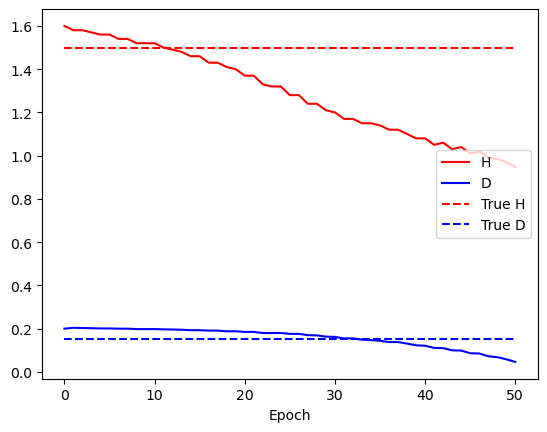

In [35]:
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-")
plt.plot(range(l), Chat[:, 1], "b-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * 1.5, "r--")
plt.plot(range(l), np.ones(Chat[:, 1].shape) * 0.15, "b--")
plt.legend(["H","D","True H","True D"], loc="right")
plt.xlabel("Epoch")

In [ ]:
# pd.Series((input_data.Tm - input_data.Te).to_numpy()[1:] / ((input_data.w.to_numpy()[1:] - input_data.w.to_numpy()[:-1]) / (input_data.index[1] - input_data.index[0])) / 2).plot()
Chat[-10:, 0:2]

In [ ]:
yhat = model.predict(observe_t)
plt.figure()
plt.plot(observe_t, y, "-", observe_t, yhat, "--")
plt.xlabel("Time")
# plt.legend(["x", "y", "z", "xh", "yh", "zh"])
# plt.title("Training data")
plt.show()